In [15]:
## multi-input time series
## include high, low, open, close, volumn

#Parameters:
num_of_year = 10
stock = 'AAPL'
num_lstm_days = 60

In [16]:
import math
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
from datetime import datetime
import os.path
from pathlib import Path

##gpu not working now...
print(tf.__version__)
print(tf.config.list_physical_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
plt.style.use('fivethirtyeight')

2.11.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Device mapping: no known devices.


In [17]:
end = datetime.today()
start = datetime(end.year-num_of_year,end.month,end.day)
df = pd.DataFrame()
my_file = Path(stock+str(start.year)+str(end.year)+".csv")
if my_file.is_file():
    df=pd.read_csv(stock+str(start.year)+str(end.year)+".csv")
else:
    print("loading_data")
    df = yf.download(stock, start=start, end=end)
    df.to_csv(stock+str(start.year)+str(end.year)+".csv")
print(df)
df = df.set_index('Date')

                           Date        Open        High         Low  \
0     2013-01-30 00:00:00-05:00   16.321428   16.521429   16.232143   
1     2013-01-31 00:00:00-05:00   16.320715   16.402857   16.249287   
2     2013-02-01 00:00:00-05:00   16.396786   16.410000   16.012501   
3     2013-02-04 00:00:00-05:00   16.211071   16.283571   15.785714   
4     2013-02-05 00:00:00-05:00   15.858929   16.419287   15.793571   
...                         ...         ...         ...         ...   
2512  2023-01-23 00:00:00-05:00  138.119995  143.320007  137.899994   
2513  2023-01-24 00:00:00-05:00  140.309998  143.160004  140.300003   
2514  2023-01-25 00:00:00-05:00  140.889999  142.429993  138.809998   
2515  2023-01-26 00:00:00-05:00  143.169998  144.250000  141.899994   
2516  2023-01-27 00:00:00-05:00  143.160004  147.229996  143.080002   

           Close   Adj Close     Volume  
0      16.315357   14.031008  417155200  
1      16.267500   13.989849  319334400  
2      16.200714   13

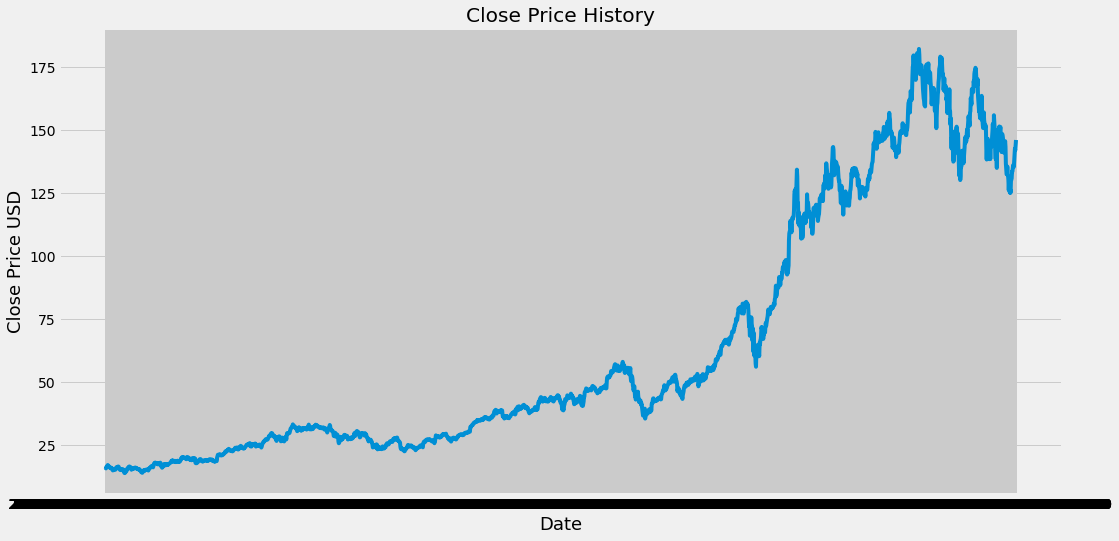

In [18]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.show()

In [19]:
high_dataset = df[['High']].values
low_dataset = df[['Low']].values
open_dataset = df[['Open']].values
volumn_dataset = df[['Volume']].values
close_dataset = df[['Close']].values

training_data_len = math.ceil(len(close_dataset)*0.8)
high_dataset

array([[ 16.52142906],
       [ 16.40285683],
       [ 16.40999985],
       ...,
       [142.42999268],
       [144.25      ],
       [147.22999573]])

In [20]:
scaler = StandardScaler()
volumn_dataset = scaler.fit_transform(volumn_dataset)

high_train_data = high_dataset[0:training_data_len, :]
low_train_data = low_dataset[0:training_data_len, :]
open_train_data = open_dataset[0:training_data_len, :]
volumn_train_data = volumn_dataset[0:training_data_len, :]
close_train_data = close_dataset[0:training_data_len, :]

hight_test_data = high_dataset[training_data_len - num_lstm_days:, :]
low_test_data = low_dataset[training_data_len - num_lstm_days:, :]
open_test_data = open_dataset[training_data_len - num_lstm_days:, :]
volumn_test_data = volumn_dataset[training_data_len - num_lstm_days:, :]
close_test_data = close_dataset[training_data_len - num_lstm_days:, :]

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(hight_test_data+low_test_data)

high_train_data = scaler.transform(high_train_data)
low_train_data = scaler.transform(low_train_data)
open_train_data = scaler.transform(open_train_data)
close_train_data = scaler.transform(close_train_data)

hight_test_data = scaler.transform(hight_test_data)
low_test_data = scaler.transform(low_test_data)
open_test_data = scaler.transform(open_test_data)
close_test_data = scaler.transform(close_test_data)

In [21]:
x_train = []
y_train = []

for i in range(num_lstm_days, len(high_train_data)):
    temp = []
    for j in range(i-num_lstm_days, i):
        temp.append([high_train_data[j,0], low_train_data[j,0], open_train_data[j,0], 
                     close_train_data[j,0], volumn_train_data[j,0] ])
    x_train.append(temp)
    y_train.append(close_train_data[i,0])

np.array(x_train).shape

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_train.shape

(1954, 60, 5)

In [31]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], x_train.shape[2]), dropout=0.1 ))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [32]:
model.fit(x_train, y_train, batch_size=64, epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 6s 71ms/step - loss: 0.1540
Epoch 2/100
31/31 [==============================] - 2s 77ms/step - loss: 0.0119
Epoch 3/100
31/31 [==============================] - 2s 76ms/step - loss: 0.0042
Epoch 4/100
31/31 [==============================] - 2s 74ms/step - loss: 0.0022
Epoch 5/100
31/31 [==============================] - 2s 75ms/step - loss: 0.0020
Epoch 6/100
31/31 [==============================] - 2s 73ms/step - loss: 0.0022
Epoch 7/100
31/31 [==============================] - 2s 76ms/step - loss: 0.0019
Epoch 8/100
31/31 [==============================] - 2s 73ms/step - loss: 0.0021
Epoch 9/100
31/31 [==============================] - 2s 74ms/step - loss: 0.0019
Epoch 10/100
31/31 [==============================] - 2s 76ms/step - loss: 0.0017
Epoch 11/100
31/31 [==============================] - 2s 74ms/step - loss: 0.0017
Epoch 12/100
11/31 [=========>....................] - ETA: 1s - loss: 0.0016

In [24]:
x_test = []
y_test = close_dataset[training_data_len:, :]

for i in range(num_lstm_days, len(hight_test_data)):
    temp = []
    for j in range(i-num_lstm_days, i):
        temp.append([hight_test_data[j,0], low_test_data[j,0], open_test_data[j,0], 
                     close_test_data[j,0], volumn_test_data[j,0] ])
    x_test.append(temp)
    
x_test = np.array(x_test)
x_test.shape

(503, 60, 5)

In [25]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


16/16 [==============================] - 1s 9ms/step


In [26]:
predictions.size

503

In [27]:
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

1.3346215887050743

In [28]:
train = df.filter(['Close'])[:training_data_len]
valid = df.filter(['Close'])[training_data_len:]
valid

,Close
Date,
2021-01-29 00:00:00-05:00,131.960007
2021-02-01 00:00:00-05:00,134.139999
2021-02-02 00:00:00-05:00,134.990005
2021-02-03 00:00:00-05:00,133.940002
2021-02-04 00:00:00-05:00,137.389999
...,...
2023-01-23 00:00:00-05:00,141.110001
2023-01-24 00:00:00-05:00,142.529999
2023-01-25 00:00:00-05:00,141.860001


In [29]:
valid['Predictions'] = predictions
prev = valid['Close'][0]
sum = 0
count = 0 
origin_volatility = []
new_volatility = []
incorrect_date = []
incorrect_date.append(0)
for idx, p in enumerate(valid['Close'][1:]):
    sum+=abs(p-prev)
    if( (p-prev>0 and valid['Predictions'][idx]-prev<0) or (p-prev<0 and valid['Predictions'][idx]-prev>0)):
        count +=1
        incorrect_date.append(10)
    else:
        incorrect_date.append(-10)
    origin_volatility.append((p-prev)*1)
    new_volatility.append((valid['Predictions'][idx]-prev)*1)
    prev=p
    
print("Avg volatility: ", sum/(valid['Close'].size-1))
print("Wrong direction count: ", count, "/", (valid['Close'].size-1))

origin_volatility.insert(0,0)
new_volatility.insert(0,0)
valid['origin_volatility'] = origin_volatility
valid['new_volatility'] = new_volatility
valid['incorrect_date'] = incorrect_date

Avg volatility:  2.1467125881240667
Wrong direction count:  251 / 502


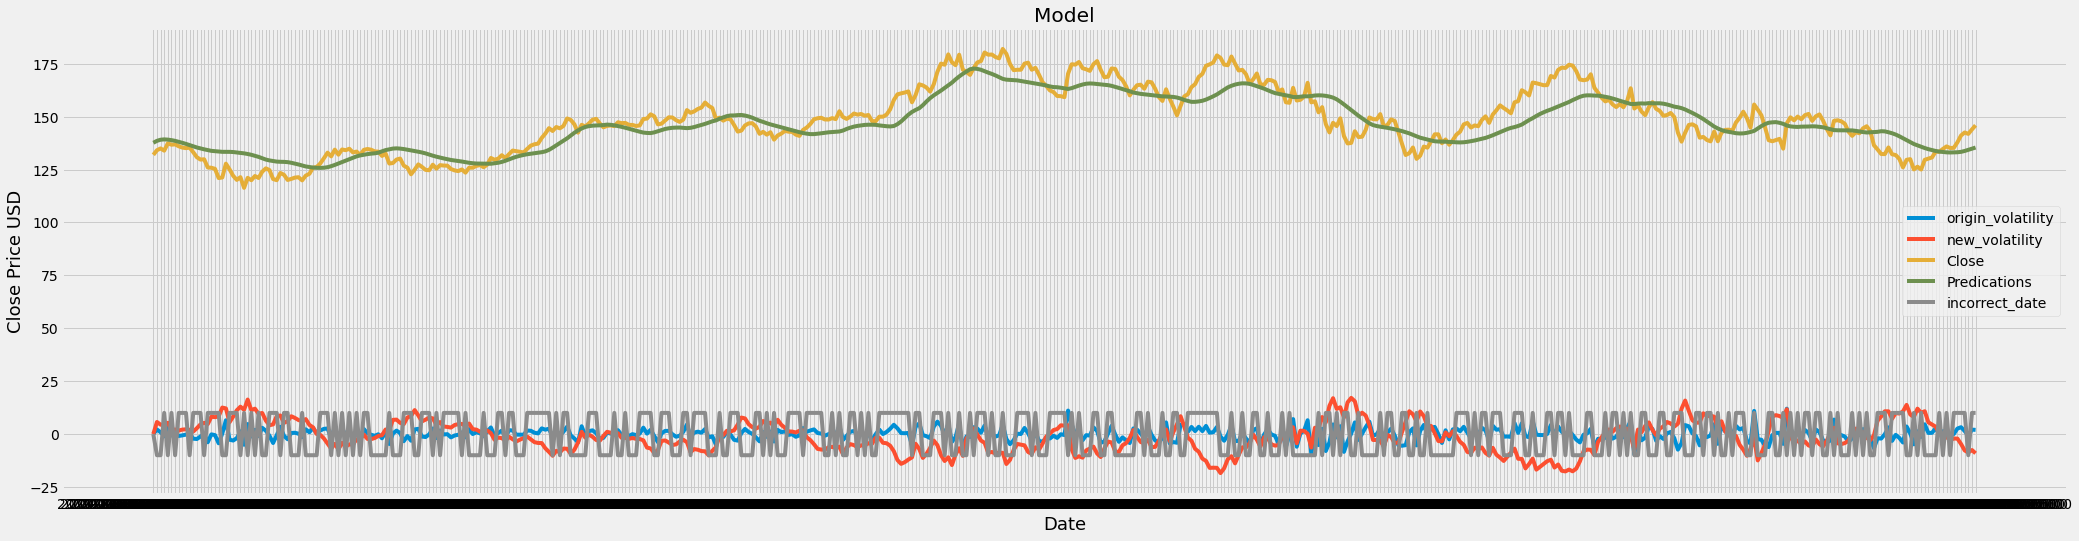

In [30]:
plt.figure(figsize=(32,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
#plt.plot(train['Close'])
plt.plot(valid[['origin_volatility','new_volatility','Close', 'Predictions','incorrect_date']])
plt.legend(['origin_volatility','new_volatility', 'Close', 'Predications','incorrect_date'])
plt.show()